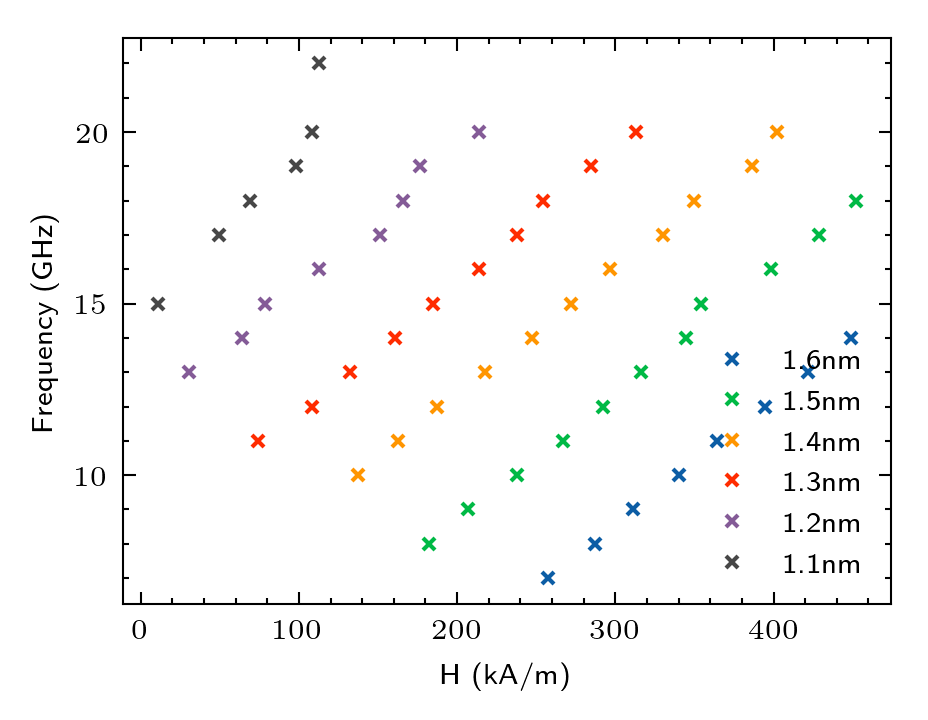

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

data = pd.read_csv('export/Kittel29xx.csv', sep=';')
with plt.style.context(['science', 'nature']):

    fig, ax = plt.subplots(dpi=300)
    cols = data.columns
    for i in range(len(cols) // 2):
        ax.plot(data[cols[2 * i]] * 80 / 1e3,
                data[cols[2 * i + 1]],
                'x',
                label=cols[2 * i].replace("H_", ""))
    ax.set_ylabel('Frequency (GHz)')
    ax.set_xlabel("H (kA/m)")
    ax.legend()

# Fitting
- Resonance of the FL
- Kittel 29 -- CoFeB thickenss changes (anisotropy changes) at tMgo = 0.75nm, Ms changes (0.86 for 1 nm to 1.3 for 1.6nm)
- Kittel 56 -- MgO thickness changes (IEC changes)  at tCoFeB = 1.3nm


In [20]:
from bayes_opt import BayesianOptimization, SequentialDomainReductionTransformer
from cmtj.models.general_sb import SolverSB, VectorObj, LayerSB
from cmtj.utils import mu0, OetoAm
from functools import partial
import json

fixed_ref_thickness = 0.5e-9
Mstop = 1.0  # T
htheta = 90  # in plane
hphi = 0


def loss(target, pred):
    return -1 * np.power(target - pred, 2).sum()


def fmr_simulation(
    Hvector,
    Ms,
    Ks,
    Kv1,
    Kv2,
    Kphi,
    thickness,
    J=1e-6,
):
    layerA = LayerSB(
        _id=0,
        thickness=thickness * 1e-9,
        Kv=VectorObj(np.deg2rad(Kphi), np.deg2rad(0), Kv1),
        Ks=Ks,
        Ms=Ms / mu0,
    )
    # reference with high in plane anisotropy
    layerB = LayerSB(
        _id=1,
        thickness=fixed_ref_thickness,
        Kv=VectorObj(np.deg2rad(0), np.deg2rad(0), Kv2),
        Ks=0,
        Ms=Mstop / mu0,
    )
    current_position = [
        np.deg2rad(90),
        np.deg2rad(180),
        np.deg2rad(90),
        np.deg2rad(180)
    ]
    f1, f2 = [], []
    for H in Hvector:
        model = SolverSB(layers=[layerA, layerB],
                         J1=[J],
                         J2=[0],
                         H=VectorObj(theta=np.deg2rad(htheta),
                                     phi=np.deg2rad(hphi),
                                     mag=H))
        eq, frequencies = model.solve(init_position=current_position,
                                      perturbation=1e-3)
        current_position = eq
        if len(frequencies) == 1:
            f1.append(frequencies[0])
            f2.append(frequencies[0])
            continue
        if len(frequencies) < 1:
            return None

        f1s = model.single_layer_resonance(0, current_position)
        _ = model.single_layer_resonance(1, current_position)

        # try to get the correct order
        if abs(f1s - frequencies[0]) > abs(f1s - frequencies[1]):
            f1.append(frequencies[1])
            f2.append(frequencies[0])
        else:
            f1.append(frequencies[0])
            f2.append(frequencies[1])

    return f1, f2


def opt_fn(Hvector, freqvector, Ms, Ks, Kv1, Kv2, Kphi, J, thickness):
    try:
        res = fmr_simulation(Hvector=Hvector,
                             Ms=Ms,
                             Ks=Ks,
                             Kv1=Kv1,
                             Kv2=Kv2,
                             Kphi=Kphi,
                             J=J,
                             thickness=thickness)
        if res is None:
            return -9e9
        f1, f2 = res
    except:
        return -9e9
    return max(loss(freqvector, f1), loss(freqvector, f2))


for th in [1.5, 1.4, 1.3, 1.2, 1.1][::-1]:
    sdf = data[[f'H_{th}nm', f'f_{th}nm']]
    sdf.dropna(inplace=True, axis=0)
    Hvector = np.asarray(sdf[f'H_{th}nm']) * OetoAm
    freqvector = np.asarray(sdf[f'f_{th}nm'])
    probe = {'Ms': 0.5, 'Ks': 1e3, 'Kv1': 1e3, 'Kv2': 1e4, 'Kphi': 0}
    bounds = {
        'Ms': (0.45, 1.8),  # T
        'Ks': (1e1, 1e6),
        'Kv1': (0, 1e4),
        'Kv2': (1e4, 1e6),
        'Kphi': (0, 10),
    }

    optimiser = BayesianOptimization(
        f=partial(opt_fn,
                  thickness=th,
                  J=1e-6,
                  Hvector=Hvector,
                  freqvector=freqvector),
        pbounds=bounds,
        random_state=42,
        bounds_transformer=SequentialDomainReductionTransformer())
    optimiser.probe(params=probe, lazy=True)
    try:
        optimiser.maximize(init_points=15, n_iter=250)
    except KeyboardInterrupt:
        print("Best target:", optimiser.max)

    f1, f2 = fmr_simulation(
        Hvector,
        J=1e-6,
        thickness=th,
        **optimiser.max['params'],
        # **probe,
    )
    # break
    with plt.style.context(['science', 'nature']):
        fig, ax = plt.subplots(1, 1, dpi=300)
        ax.plot(Hvector / 1e3,
                freqvector,
                'o',
                color='royalblue',
                label='data')
        ax.plot(Hvector / 1e3,
                np.asarray(f1),
                'x-',
                color='crimson',
                label='fit 1')
        ax.plot(Hvector / 1e3,
                np.asarray(f2),
                'x-',
                color='navy',
                label='fit 2')
        ax.set_xlabel('Field [kOe]')
        ax.set_ylabel('Frequency [GHz]')
        ax.set_title(
            f"fit error: {max(loss(freqvector, f1), loss(freqvector, f2)):.2f}"
        )
        ax.legend()
        fig.savefig(f'optim_{th}nm.png')
        json.dump(optimiser.max['params'], open(f'optim_{th}nm.json', 'w'))

/opt/homebrew/Caskroom/miniforge/base/envs/.cmtj/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


|   iter    |  target   |   Kphi    |    Ks     |    Kv1    |    Kv2    |    Ms     |
-------------------------------------------------------------------------------------
| 1         | -486.0    | 0.0       | 1e+03     | 1e+03     | 1e+04     | 0.5       |
| 2         | -6.797e+0 | 3.745     | 9.507e+05 | 7.32e+03  | 6.027e+05 | 0.6606    |
| 3         | -460.5    | 1.56      | 5.809e+04 | 8.662e+03 | 6.051e+05 | 1.406     |
| 4         | -198.6    | 0.2058    | 9.699e+05 | 8.324e+03 | 2.202e+05 | 0.6955    |
| 5         | -1.612e+0 | 1.834     | 3.042e+05 | 5.248e+03 | 4.376e+05 | 0.8432    |
| 6         | -691.8    | 6.119     | 1.395e+05 | 2.921e+03 | 3.727e+05 | 1.066     |
| 7         | -309.6    | 7.852     | 1.997e+05 | 5.142e+03 | 5.965e+05 | 0.5127    |
| 8         | -406.5    | 6.075     | 1.705e+05 | 650.5     | 9.494e+05 | 1.754     |
| 9         | -1.047e+0 | 8.084     | 3.046e+05 | 976.7     | 6.874e+05 | 1.044     |
| 10        | -33.73    | 1.22      | 4.952e+05 | 343.

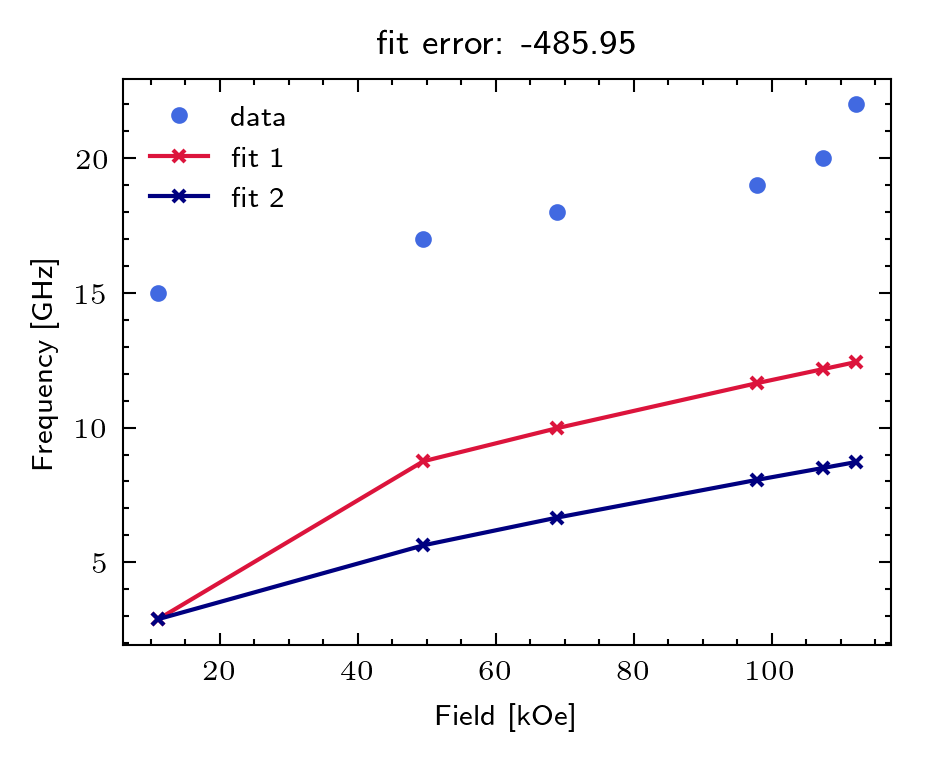

In [19]:

# f1 = fmr_simulation(
#     Hvector,
#     J=1e-6,
#     thickness=th,
#     Kv2=0,
# #     **optimiser.max['params'],
#     **probe,
# )
f1, f2 = r
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(1, 1, dpi=300)
    ax.plot(Hvector / 1e3,
            freqvector,
            'o',
            color='royalblue',
            label='data')
    ax.plot(Hvector / 1e3,
            np.asarray(f1),
            'x-',
            color='crimson',
            label='fit 1')
    ax.plot(Hvector / 1e3,
            np.asarray(f2),
            'x-',
            color='navy',
            label='fit 2')
    ax.set_xlabel('Field [kOe]')
    ax.set_ylabel('Frequency [GHz]')
    ax.set_title(f"fit error: {loss(freqvector, f1):.2f}")
    ax.set_title(
    f"fit error: {max(loss(freqvector, f1), loss(freqvector, f2)):.2f}"
    ) 
    ax.legend()
#     fig.savefig(f'optim_{th}nm.png')
#     json.dump(optimiser.max['params'], open(f'optim_{th}nm.json', 'w'))

/opt/homebrew/Caskroom/miniforge/base/envs/.cmtj/lib/python3.9/site-packages/pandas/util/_decorators.py:311: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return func(*args, **kwargs)


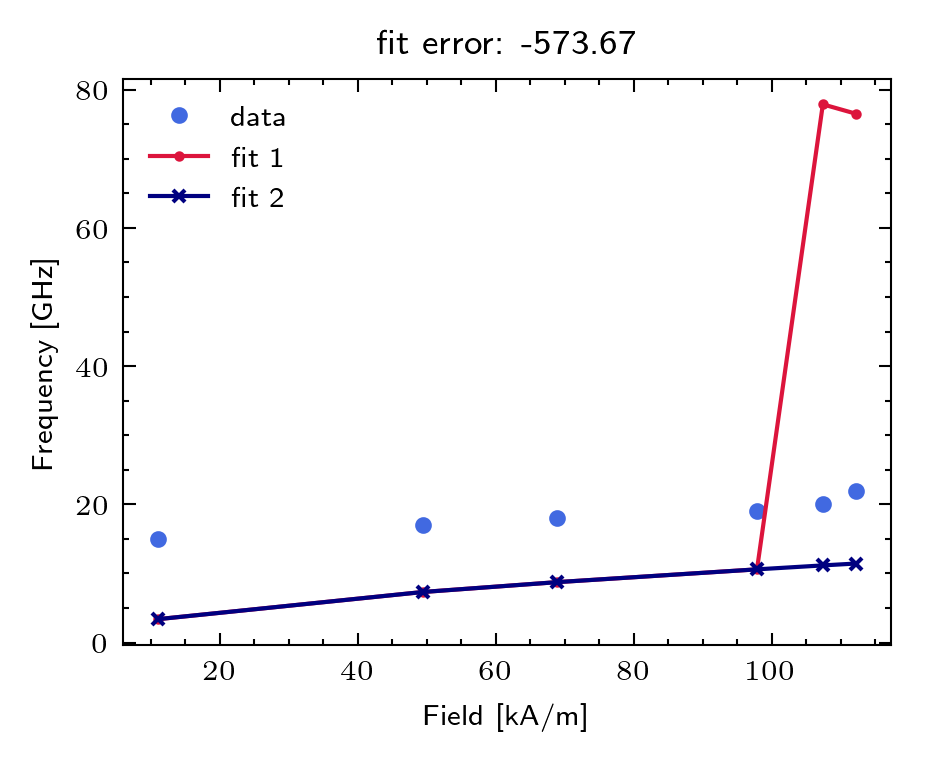

In [85]:
import json
from functools import partial

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from bayes_opt import (BayesianOptimization,
                       SequentialDomainReductionTransformer)

from cmtj.models.general_sb import LayerSB, SolverSB, VectorObj
from cmtj.utils import OetoAm, mu0

data = pd.read_csv('export/Kittel29xx.csv', sep=';')

fixed_ref_thickness = 0.5e-9
Mstop = 0.5  # T
htheta = 90  # in plane
hphi = 0


def loss(target, pred):
    return -1 * np.power(target - pred, 2).sum()


def fmr_simulation(
    Hvector,
    Ms,
    Ks1,
    Ks2,
    thickness,
    J=1e-6,
):
    layerA = LayerSB(
        _id=0,
        thickness=thickness * 1e-9,
        Kv=VectorObj(np.deg2rad(0), np.deg2rad(0), 100),
        Ks=Ks1,
        Ms=Ms / mu0,
    )
    # reference with high in plane anisotropy
    layerB = LayerSB(
        _id=1,
        thickness=fixed_ref_thickness,
        Kv=VectorObj(np.deg2rad(0), np.deg2rad(0), 100),
        Ks=Ks2,
        Ms=Mstop / mu0,
    )
    current_position = [
        np.deg2rad(90),
        np.deg2rad(180),
        np.deg2rad(90),
        np.deg2rad(180),
        # np.deg2rad(90),
        # np.deg2rad(180)
    ]
    f1, f2 = [], []
    for H in Hvector:
        model = SolverSB(layers=[layerA, layerB],
                         J1=[J],
                         J2=[0],
                         H=VectorObj(theta=np.deg2rad(htheta),
                                     phi=np.deg2rad(hphi),
                                     mag=H))
        eq, frequencies = model.solve(init_position=current_position,
                                      perturbation=1e-3)
        current_position = eq
        if len(frequencies) == 1:
            f1.append(frequencies[0])
            f2.append(frequencies[0])
            continue
        if len(frequencies) < 1:
            return None

        f1s = model.single_layer_resonance(0, current_position)
        _ = model.single_layer_resonance(1, current_position)

        # try to get the correct order
        if abs(f1s - frequencies[0]) > abs(f1s - frequencies[1]):
            f1.append(frequencies[1])
            f2.append(frequencies[0])
        else:
            f1.append(frequencies[0])
            f2.append(frequencies[1])

    return f1, f2


Msbounds_ = [
    (1.2, 1.4),  # 1.6
    (1.15, 1.3),  # 1.5
    (1., 1.25),  # 1.4
    (1., 1.25),  # 1.3
    (0.9, 1.2),  # 1.2
    (0.86, 1.1),  # 1.1
]
th = 1.1
i = 0
probe = {'Ms': 1.46, 'Ks1': 2.468e05, 'Ks2': 4.823e5, 'J': 1.e-5}
sdf = data[[f'H_{th}nm', f'f_{th}nm']]
sdf.dropna(inplace=True, axis=0)
Hvector = np.asarray(sdf[f'H_{th}nm']) * OetoAm
freqvector = np.asarray(sdf[f'f_{th}nm'])

f1, f2 = fmr_simulation(
    Hvector,
    # J=1e-6,
    thickness=th,
    **probe,
    # **probe,
)
with plt.style.context(['science', 'nature']):
    fig, ax = plt.subplots(1, 1, dpi=300)
    ax.plot(Hvector / 1e3, freqvector, 'o', color='royalblue', label='data')
    ax.plot(Hvector / 1e3,
            np.asarray(f1),
            '.-',
            color='crimson',
            label='fit 1')
    ax.plot(Hvector / 1e3, np.asarray(f2), 'x-', color='navy', label='fit 2')
    ax.set_xlabel('Field [kA/m]')
    ax.set_ylabel('Frequency [GHz]')
    ax.set_title(
        f"fit error: {max(loss(freqvector, f1), loss(freqvector, f2)):.2f}")
    ax.legend()

In [55]:

Msa = (0.9/mu0)
Kdemag = 0.5*mu0*Msa**2
print(Kdemag/1e3)

322.2982651599554
